In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#https://drive.google.com/file/d/183B_W_R2qSnT_JjEUcI3Ny1vH36desCp/view?usp=sharing
file1 = drive.CreateFile({'id':'183B_W_R2qSnT_JjEUcI3Ny1vH36desCp'}) # replace the id with id of file you want to access
file1.GetContentFile('credit_train.csv')

In [ ]:
#https://drive.google.com/file/d/1ceLPls-2L2RuPoAJXAwGgcqxufoHAs0t/view?usp=sharing
file2 = drive.CreateFile({'id':'1ceLPls-2L2RuPoAJXAwGgcqxufoHAs0t'}) # replace the id with id of file you want to access
file2.GetContentFile('credit_test.csv')

In [54]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
df_train = pd.read_csv('credit_train.csv')
df_test = pd.read_csv('credit_test.csv')

In [55]:
df_train = pd.read_csv('./datasets/credit_train.csv')
df_test = pd.read_csv('./datasets/credit_test.csv')

In [3]:
print(df_train.shape)
print(df_test.shape)

(100514, 19)
(10353, 18)


In [56]:
df = pd.concat([df_train, df_test])
df.shape

(110867, 19)

In [5]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


In [6]:
df.info()
#non numerica type columns: Loan_ID, Customer ID, Loan Status, Term, Years in Current job, Home Ownership, Purpose

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110867 entries, 0 to 10352
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       110000 non-null  object 
 1   Customer ID                   110000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           110000 non-null  float64
 4   Term                          110000 non-null  object 
 5   Credit Score                  88865 non-null   float64
 6   Annual Income                 88865 non-null   float64
 7   Years in current job          105351 non-null  object 
 8   Home Ownership                110000 non-null  object 
 9   Purpose                       110000 non-null  object 
 10  Monthly Debt                  110000 non-null  float64
 11  Years of Credit History       110000 non-null  float64
 12  Months since last delinquent  51553 non-null 

In [7]:
len(df)

110867

In [8]:
#check missing values 
df.isna().sum()

Loan ID                           867
Customer ID                       867
Loan Status                     10867
Current Loan Amount               867
Term                              867
Credit Score                    22002
Annual Income                   22002
Years in current job             5516
Home Ownership                    867
Purpose                           867
Monthly Debt                      867
Years of Credit History           867
Months since last delinquent    59314
Number of Open Accounts           867
Number of Credit Problems         867
Current Credit Balance            867
Maximum Open Credit               869
Bankruptcies                     1093
Tax Liens                         878
dtype: int64

In [9]:
print(df['Months since last delinquent'].isna().sum()/len(df))

0.5350013980715632


In [10]:
type(df['Months since last delinquent'])

pandas.core.series.Series

In [11]:
print(df.shape)
print(min(df['Credit Score']))
print(max(df['Credit Score']))

(110867, 19)
585.0
7510.0


In [12]:
## Convert credit score which value higher than 5000 ten times smaller
arr = df['Credit Score'].isnull().values
Shape = df.shape
for i in range(Shape[0]):
    ## skip all na values
    if arr[i] == False:
        if df['Credit Score'].values[i] > 5000:
            tmp = df['Credit Score'].values[i]
            tmp = (tmp*10)/100
            df['Credit Score'].values[i] = tmp

In [13]:
print(df.shape)
print(min(df['Credit Score']))
print(max(df['Credit Score']))

(110867, 19)
585.0
751.0


In [14]:
#Overall, we need to impute missing values for all the columns, since missing values for Months since last delinquent take up over 50% 
from sklearn.impute import SimpleImputer
#impute missing values for numerical data : mean
# Select numeric columns.
numeric = df.select_dtypes('number')
# # Select string and object columns.
categoric = df.select_dtypes('object')

# # # Fill numeric columns with mean.
df[numeric.columns] = numeric.fillna(numeric.mean())
# # # Fill object columns with mode.
df[categoric.columns] = categoric.fillna(categoric.agg(lambda x: x.mode().values[0]))

In [ ]:
## Drop na
# df.dropna(axis=0, inplace=True)
# df.reset_index(inplace=True)
# df.drop(columns = ['index'], inplace=True)
# df.head()

In [15]:
#double check missing values
df.isna().sum()

Loan ID                         0
Customer ID                     0
Loan Status                     0
Current Loan Amount             0
Term                            0
Credit Score                    0
Annual Income                   0
Years in current job            0
Home Ownership                  0
Purpose                         0
Monthly Debt                    0
Years of Credit History         0
Months since last delinquent    0
Number of Open Accounts         0
Number of Credit Problems       0
Current Credit Balance          0
Maximum Open Credit             0
Bankruptcies                    0
Tax Liens                       0
dtype: int64

In [16]:
#check unique values for each column
df.nunique()
#meaningful columns often have fewer number of unique colunmns
#we need to conduct some transformation for those columns which are categorical 

Loan ID                         88354
Customer ID                     88354
Loan Status                         2
Current Loan Amount             22503
Term                                2
Credit Score                      168
Annual Income                   37854
Years in current job               11
Home Ownership                      4
Purpose                            16
Monthly Debt                    69751
Years of Credit History           508
Months since last delinquent      117
Number of Open Accounts            53
Number of Credit Problems          15
Current Credit Balance          33642
Maximum Open Credit             46469
Bankruptcies                        9
Tax Liens                          14
dtype: int64

In [17]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.00000,1.167493e+06,8 years,Home Mortgage,Home Improvements,5214.74,17.2,34.907086,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,716.32393,1.377449e+06,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.000000,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.00000,2.231892e+06,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.000000,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.00000,8.069490e+05,3 years,Own Home,Debt Consolidation,8741.90,12.0,34.907086,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,716.32393,1.377449e+06,5 years,Rent,Debt Consolidation,20639.70,6.1,34.907086,15.0,0.0,253460.0,427174.0,0.0,0.0


In [18]:
df[categoric.columns].nunique()

Loan ID                 88354
Customer ID             88354
Loan Status                 2
Term                        2
Years in current job       11
Home Ownership              4
Purpose                    16
dtype: int64

In [19]:
#feature encoding for categorical varaibles
#label encoding: convert each value in a column to a number 
#All the categorical variables except years in current job can be handled with label encoding 
#Years in current job are required to be transformed into numerical variables
#Home ownership and purpose don't have seuqntial characteristic, not use label encoding
#create initial categorical dataframe

categoric_cols = list(categoric.columns)
categoric_cols.remove('Years in current job')
categoric_cols

['Loan ID', 'Customer ID', 'Loan Status', 'Term', 'Home Ownership', 'Purpose']

In [20]:
#creatin instance of labelencoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[categoric_cols] = df[categoric_cols].apply(le.fit_transform)

In [21]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,7224,52478,1,445412.0,1,709.00000,1.167493e+06,8 years,1,5,5214.74,17.2,34.907086,6.0,1.0,228190.0,416746.0,1.0,0.0
1,24818,15821,1,262328.0,1,716.32393,1.377449e+06,10+ years,1,3,33295.98,21.1,8.000000,35.0,0.0,229976.0,850784.0,0.0,0.0
2,27403,32811,1,99999999.0,1,741.00000,2.231892e+06,8 years,2,3,29200.53,14.9,29.000000,18.0,1.0,297996.0,750090.0,0.0,0.0
3,41293,79892,1,347666.0,0,721.00000,8.069490e+05,3 years,2,3,8741.90,12.0,34.907086,9.0,0.0,256329.0,386958.0,0.0,0.0
4,73291,44636,1,176220.0,1,716.32393,1.377449e+06,5 years,3,3,20639.70,6.1,34.907086,15.0,0.0,253460.0,427174.0,0.0,0.0


In [22]:
#convert 'years in current job' to numerical type
## Not sure how to convert 10+ years and less than 1 year to numeric type
## So I used 0 for less than 1 year, and 10 for 10+ years
label = "Years in current job"
df[label] = df[label].replace({'< 1 year':0, '1 year': 1, '2 years': 2,
                                          '3 years':3, '4 years':4, '5 years':5, 
                                          '6 years':6, '7 years':7, '8 years':8, 
                                          '9 years': 9, '10+ years': 10})

In [23]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,7224,52478,1,445412.0,1,709.00000,1.167493e+06,8,1,5,5214.74,17.2,34.907086,6.0,1.0,228190.0,416746.0,1.0,0.0
1,24818,15821,1,262328.0,1,716.32393,1.377449e+06,10,1,3,33295.98,21.1,8.000000,35.0,0.0,229976.0,850784.0,0.0,0.0
2,27403,32811,1,99999999.0,1,741.00000,2.231892e+06,8,2,3,29200.53,14.9,29.000000,18.0,1.0,297996.0,750090.0,0.0,0.0
3,41293,79892,1,347666.0,0,721.00000,8.069490e+05,3,2,3,8741.90,12.0,34.907086,9.0,0.0,256329.0,386958.0,0.0,0.0
4,73291,44636,1,176220.0,1,716.32393,1.377449e+06,5,3,3,20639.70,6.1,34.907086,15.0,0.0,253460.0,427174.0,0.0,0.0


### Categorize credit score into differnt ranges

In [24]:
min_cs = min(df['Credit Score'])
max_cs = max(df['Credit Score'])
binSize=6
per_bin = (max_cs - min_cs)/binSize

bin = []
bin.append(min_cs)
CS_count = []
for i in range(7):
    if i == 6:
        bin.append(round(max_cs,0))
    else:
        bin.append(round(bin[i]+per_bin,0))  
    if(i < 6):
        CS_count.append(0)

def label_cs(row):
    if bin[0] <= row['Credit Score'] and row['Credit Score'] <= bin[1]:
        i = 1
        CS_count[i-1] = CS_count[i-1] + 1
        return i
    elif row['Credit Score'] <= bin[2]:
        i = 2
        CS_count[i-1] = CS_count[i-1] + 1
        return i
    elif row['Credit Score'] <= bin[3]:
        i = 3
        CS_count[i-1] = CS_count[i-1] + 1
        return i
    elif row['Credit Score'] <= bin[4]:
        i = 4
        CS_count[i-1] = CS_count[i-1] + 1
        return i
    elif row['Credit Score'] <= bin[5]:
        i = 5
        CS_count[i-1] = CS_count[i-1] + 1
        return i
    elif row['Credit Score'] <= bin[6]:
        i = 6
        CS_count[i-1] = CS_count[i-1] + 1
        return i  
df['Credit Score category'] = df.apply(lambda row: label_cs(row),axis=1)
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Credit Score category
0,7224,52478,1,445412.0,1,709.00000,1.167493e+06,8,1,5,5214.74,17.2,34.907086,6.0,1.0,228190.0,416746.0,1.0,0.0,5
1,24818,15821,1,262328.0,1,716.32393,1.377449e+06,10,1,3,33295.98,21.1,8.000000,35.0,0.0,229976.0,850784.0,0.0,0.0,5
2,27403,32811,1,99999999.0,1,741.00000,2.231892e+06,8,2,3,29200.53,14.9,29.000000,18.0,1.0,297996.0,750090.0,0.0,0.0,6
3,41293,79892,1,347666.0,0,721.00000,8.069490e+05,3,2,3,8741.90,12.0,34.907086,9.0,0.0,256329.0,386958.0,0.0,0.0,5
4,73291,44636,1,176220.0,1,716.32393,1.377449e+06,5,3,3,20639.70,6.1,34.907086,15.0,0.0,253460.0,427174.0,0.0,0.0,5


In [25]:
for i in range(7):
    print("Range", i+1, ":", bin[i])

Range 1 : 585.0
Range 2 : 613.0
Range 3 : 641.0
Range 4 : 669.0
Range 5 : 697.0
Range 6 : 725.0
Range 7 : 753.0


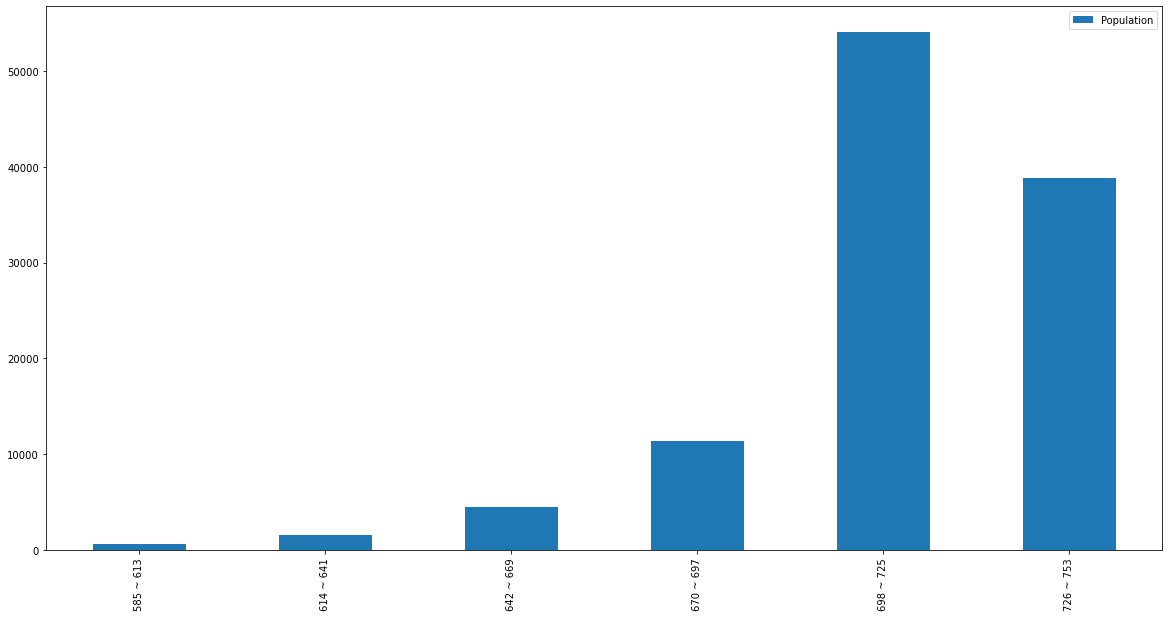

In [26]:
CS_category = pd.DataFrame({
   'Population':CS_count, 
   }, index = ['585 ~ 613', '614 ~ 641','642 ~ 669','670 ~ 697','698 ~ 725', '726 ~ 753'])
CS_category.plot.bar(figsize=(20,10))

In [27]:
## Double check the size of all range
total = 0
for i in range(6):
    total = total + CS_count[i]
most = CS_count[4] + CS_count[5]
most/total

0.8378597779321169

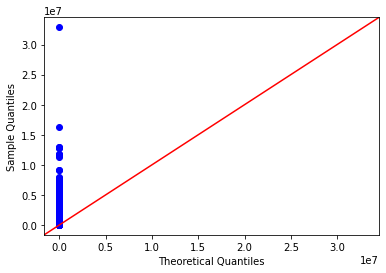

In [28]:
#use qq plot to show some distributions of variables
import statsmodels.api as sm
from scipy.stats import norm
import pylab
current_credit = df['Current Credit Balance']
sm.qqplot(current_credit, line='45')
pylab.show()
# our QQ plot shows that current loan amount has too many values at the lower end 

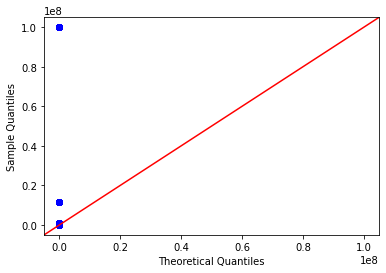

In [29]:
import statsmodels.api as sm
from scipy.stats import norm
import pylab
current_loan = df['Current Loan Amount']
sm.qqplot(current_loan, line='45')
pylab.show()
#there are also too many lower end values for current loan amount 

In [30]:
df[numeric.columns].isna().sum()

Current Loan Amount             0
Credit Score                    0
Annual Income                   0
Monthly Debt                    0
Years of Credit History         0
Months since last delinquent    0
Number of Open Accounts         0
Number of Credit Problems       0
Current Credit Balance          0
Maximum Open Credit             0
Bankruptcies                    0
Tax Liens                       0
dtype: int64

In [31]:
df[numeric.columns]

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,4.454120e+05,709.00000,1.167493e+06,5214.740000,17.200000,34.907086,6.000000,1.000000,228190.000000,416746.000000,1.000000,0.000000
1,2.623280e+05,716.32393,1.377449e+06,33295.980000,21.100000,8.000000,35.000000,0.000000,229976.000000,850784.000000,0.000000,0.000000
2,1.000000e+08,741.00000,2.231892e+06,29200.530000,14.900000,29.000000,18.000000,1.000000,297996.000000,750090.000000,0.000000,0.000000
3,3.476660e+05,721.00000,8.069490e+05,8741.900000,12.000000,34.907086,9.000000,0.000000,256329.000000,386958.000000,0.000000,0.000000
4,1.762200e+05,716.32393,1.377449e+06,20639.700000,6.100000,34.907086,15.000000,0.000000,253460.000000,427174.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
10348,1.174621e+07,716.32393,1.377449e+06,18468.526823,18.202485,34.907086,11.124491,0.168055,294282.171564,754101.205331,0.117614,0.029448
10349,1.174621e+07,716.32393,1.377449e+06,18468.526823,18.202485,34.907086,11.124491,0.168055,294282.171564,754101.205331,0.117614,0.029448
10350,1.174621e+07,716.32393,1.377449e+06,18468.526823,18.202485,34.907086,11.124491,0.168055,294282.171564,754101.205331,0.117614,0.029448
10351,1.174621e+07,716.32393,1.377449e+06,18468.526823,18.202485,34.907086,11.124491,0.168055,294282.171564,754101.205331,0.117614,0.029448


In [32]:
#conduct normalization since our dataset is not normally distributed based on our observations
# normalization (x-x_min)/(x_max-x_min) 
#advantge of normalization: 
#1. improve training process
#2. all data are within the same scale
#3. logistic regression, SVM requires normalization
from sklearn import preprocessing
# normalize the continuous variable
df_tmp = df.drop(columns = ['Credit Score category'])
numeric = df_tmp.select_dtypes('number')
numeric_vals = numeric.values#numpy array
transformer = preprocessing.MinMaxScaler()
numeric_normalized = transformer.fit_transform(numeric_vals)
numeric_names = list(numeric.columns)
df[numeric_names] = numeric_normalized

In [33]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Credit Score category
0,0.081763,0.593958,1.0,0.004347,1.0,0.746988,0.006592,0.8,0.333333,0.333333,0.011965,0.203288,0.198336,0.078947,0.066667,0.006940,0.000271,0.142857,0.0,5
1,0.280896,0.179066,1.0,0.002516,1.0,0.791108,0.007861,1.0,0.333333,0.200000,0.076394,0.261584,0.045455,0.460526,0.000000,0.006995,0.000553,0.000000,0.0,5
2,0.310154,0.371363,1.0,1.000000,1.0,0.939759,0.013024,0.8,0.666667,0.200000,0.066998,0.168909,0.164773,0.236842,0.066667,0.009063,0.000487,0.000000,0.0,6
3,0.467364,0.904236,1.0,0.003369,0.0,0.819277,0.004413,0.3,0.666667,0.200000,0.020057,0.125561,0.198336,0.118421,0.000000,0.007796,0.000251,0.000000,0.0,5
4,0.829525,0.505201,1.0,0.001654,1.0,0.791108,0.007861,0.5,1.000000,0.200000,0.047356,0.037369,0.198336,0.197368,0.000000,0.007709,0.000277,0.000000,0.0,5


In [34]:
## double check na
df.isna().sum()

Loan ID                         0
Customer ID                     0
Loan Status                     0
Current Loan Amount             0
Term                            0
Credit Score                    0
Annual Income                   0
Years in current job            0
Home Ownership                  0
Purpose                         0
Monthly Debt                    0
Years of Credit History         0
Months since last delinquent    0
Number of Open Accounts         0
Number of Credit Problems       0
Current Credit Balance          0
Maximum Open Credit             0
Bankruptcies                    0
Tax Liens                       0
Credit Score category           0
dtype: int64

In [35]:
to_drop = ["Credit Score"]
X = df.drop(to_drop, axis = 1)
y = df["Credit Score"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 83150 observation with 19 features
test data has 27717 observation with 19 features


### Part2: Check features correlation

In [37]:
df_corr = df.drop(columns = ['Loan ID', 'Customer ID'])

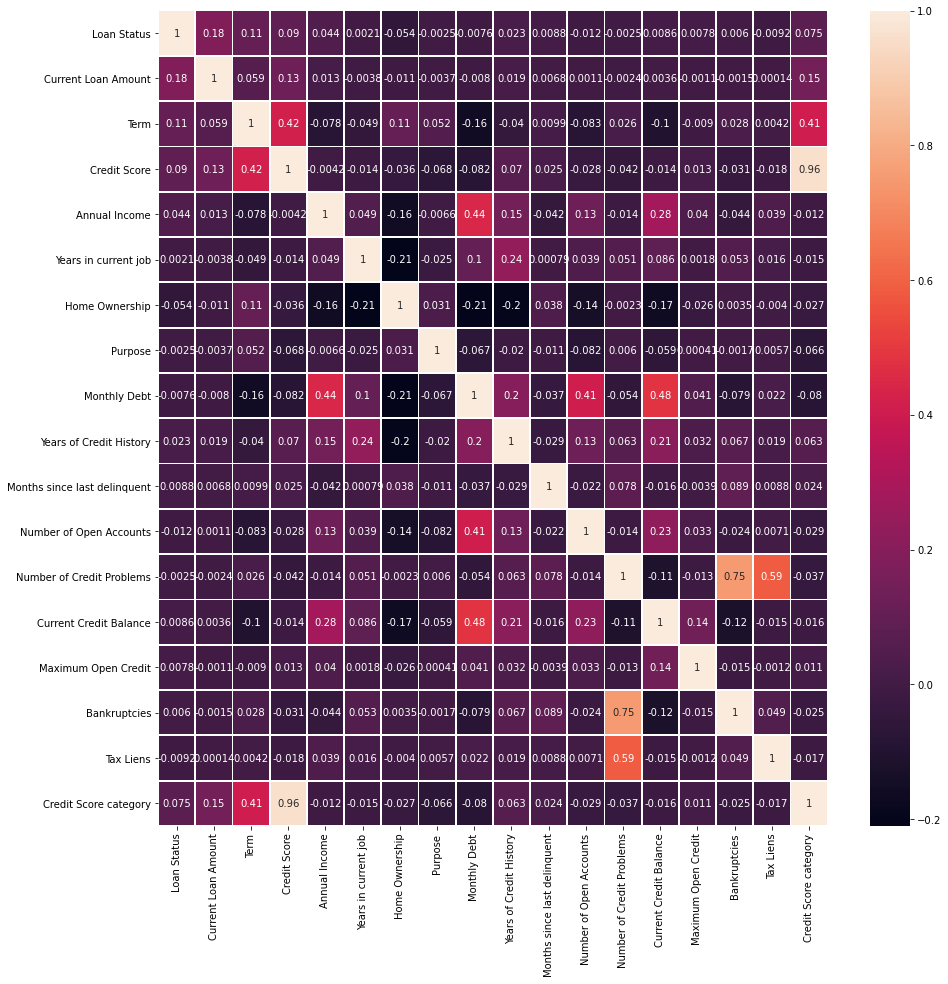

In [38]:
## Bankruptcies and Number of credit problems have relatively strong positive correlation
## Number of credit problems and Tax lien have relatively strong postiive correlation
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_corr.corr(), annot = True,linewidths=.8, ax=ax)

Part3:Model training and testing

In [ ]:
#grid search to find the optimal hyperparameter
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
X = df.drop(columns = ['Loan ID', 'Customer ID', 'Credit Score category', 'Credit Score'])
y = df['Credit Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)
y_pred_train = LR_model.predict(X_train)
## model evaluation
print("MSE for testing set: ", mean_squared_error(y_test, y_pred), "\n")
print("MSE for training set: ", mean_squared_error(y_train, y_pred_train), "\n")
## The best R2 score is 1, it can be negative because the model is arbitrarily worse
print("R2 score for testing set: ", r2_score(y_test, y_pred), "\n")
print("R2 score for training set: ", r2_score(y_train, y_pred_train), "\n")

MSE for testing set:  0.018133562136327202 

MSE for training set:  0.018258482269977158 

R2 score for testing set:  0.21932209030156347 

R2 score for training set:  0.21652481341871666 



In [ ]:
from sklearn.preprocessing import PolynomialFeatures
X = df.drop(columns = ['Loan ID', 'Customer ID', 'Credit Score category','Credit Score'])
y = df['Credit Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

poly = PolynomialFeatures(degree=3)
X_deg = X
X_deg = poly.fit_transform(X_deg)

X_train, X_test, y_train, y_test = train_test_split(X_deg, y, test_size=0.3, random_state=1)

poly_model = LinearRegression()
poly_model.fit(X_train, y_train)
y_pred = poly_model.predict(X_test)
y_pred_train = poly_model.predict(X_train)
## model evaluation
print("MSE for testing set: ", mean_squared_error(y_test, y_pred), "\n")
print("MSE for training set: ", mean_squared_error(y_train, y_pred_train), "\n")
## The best R2 score is 1, it can be negative because the model is arbitrarily worse
print("R2 score for testing set: ", r2_score(y_test, y_pred), "\n")
print("R2 score for training set: ", r2_score(y_train, y_pred_train), "\n")

In [40]:
from sklearn import svm
from sklearn.metrics import accuracy_score

X = df.drop(columns = ['Loan ID', 'Customer ID','Credit Score category', 'Months since last delinquent','Credit Score'])
y = df['Credit Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
clf = svm.SVR(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print("MSE for testing set: ", mean_squared_error(y_test, y_pred), "\n")
print("MSE for training set: ", mean_squared_error(y_train, y_pred_train), "\n")
print("R2 score for testing set: ", r2_score(y_test, y_pred), "\n")
print("R2 score for training set: ", r2_score(y_train, y_pred_train), "\n")
#print("Accuracy:",accuracy_score(y_test, y_pred))

MSE for testing set:  0.01809416071432137 

MSE for training set:  0.018137438739895227 

R2 score for testing set:  0.22101838248836092 

R2 score for training set:  0.22171881590551357 



In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
X = df.drop(columns=['Credit Score','Loan ID', 'Customer ID', 'Credit Score category'])
y = df['Credit Score category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Logis_model = LogisticRegression()
Logis_model.fit(X_train, y_train)
y_pred = Logis_model.predict(X_test)
y_pred_train = Logis_model.predict(X_train)
## model evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       174
           2       0.00      0.00      0.00       470
           3       0.00      0.00      0.00      1301
           4       0.20      0.00      0.00      3376
           5       0.52      0.88      0.66     16187
           6       0.62      0.31      0.42     11753

    accuracy                           0.54     33261
   macro avg       0.22      0.20      0.18     33261
weighted avg       0.49      0.54      0.47     33261



D:\AInstall\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\AInstall\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### One-hot encode credit score category for NN model

In [47]:
df_oneHot = df
df_oneHot.head()

## one hot encode Credit Score category
CSC = df_oneHot['Credit Score category']
## One hot encode the "Credit Score category" attribute
CSC_encoded = pd.get_dummies(CSC, prefix='Credit Score category')
## merge the encoded "Credit Score category" into the dataset
df_oneHot = CSC_encoded.merge(df_oneHot, left_index=True, right_index=True)
## Drop the original "Credit Score category" column
df_oneHot = df_oneHot.drop(columns = ['Credit Score category'])

df_oneHot.head()

,Credit Score category_1,Credit Score category_2,Credit Score category_3,Credit Score category_4,Credit Score category_5,Credit Score category_6,Loan ID,Customer ID,Loan Status,Current Loan Amount,...,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,0,0,0,0,1,0,0.081763,0.593958,1.0,0.004347,...,0.333333,0.011965,0.203288,0.198336,0.078947,0.066667,0.006940,0.000271,0.142857,0.0
0,0,0,0,0,1,0,0.966419,0.870214,1.0,0.006006,...,0.200000,0.096367,0.272048,0.198336,0.118421,0.000000,0.018915,0.000688,0.000000,0.0
0,0,0,0,0,0,1,0.081763,0.593958,1.0,0.004347,...,0.333333,0.011965,0.203288,0.198336,0.078947,0.066667,0.006940,0.000271,0.142857,0.0
0,0,0,0,0,0,1,0.966419,0.870214,1.0,0.006006,...,0.200000,0.096367,0.272048,0.198336,0.118421,0.000000,0.018915,0.000688,0.000000,0.0
1,0,0,0,0,1,0,0.280896,0.179066,1.0,0.002516,...,0.200000,0.076394,0.261584,0.045455,0.460526,0.000000,0.006995,0.000553,0.000000,0.0


In [49]:
#df_oneHot_shorten = df_oneHot.iloc[:10000]
df_oneHot_shorten = df_oneHot

In [52]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.utils import class_weight
from tensorflow.keras import layers
ylabel = ['Credit Score category_1','Credit Score category_2','Credit Score category_3',
          'Credit Score category_4','Credit Score category_5','Credit Score category_6']
y = df_oneHot_shorten[ylabel]
xlabel = ['Credit Score','Loan ID', 'Customer ID', 'Months since last delinquent',
            'Credit Score category_1','Credit Score category_2','Credit Score category_3',
            'Credit Score category_4','Credit Score category_5','Credit Score category_6']
X = df_oneHot_shorten.drop(columns = xlabel)

# X = df.drop(columns = ['Loan ID', 'Customer ID','Credit Score category'])
# y = df['Credit Score']

hiddenNodes = 32
outputNode = 6
epochSize = 100
batchSize = 32
learningRate = 0.001
precision = keras.metrics.Precision(name="precision")
recallM = keras.metrics.Recall(name="recall")
AUC = keras.metrics.AUC(name="auc")
#optimizer = keras.optimizers.SGD(learning_rate=learningRate)
optimizer = keras.optimizers.Adam(learning_rate=learningRate)

# split into train and test sets
X_train, Xval_test, y_train, yval_test = train_test_split(X, y, test_size=0.3)
xval,xtest,yval,ytest = train_test_split(Xval_test,yval_test,test_size = 0.5)

input_layer = keras.Input(shape=X.shape)
model = Sequential()
model.add(tf.keras.Input(shape=X.shape, name="input"))
model.add(Dense(hiddenNodes, activation='relu', name="hiddenlayer1"))
#model.add(Dense(hiddenNodes, activation='relu', name="hiddenlayer2"))
model.add(Dense(outputNode, activation='softmax', name="outputlayer"))
# Compile model (required to make predictions)
lossFun =  tf.keras.losses.MeanSquaredError()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy', 'mse', precision, recallM, AUC])


modelFit = model.fit(X_train, y_train, validation_data = (xval, yval), 
                    verbose = 0, epochs=epochSize, batch_size=batchSize)

In [53]:
## Getting all the evaluation scores
loss, acc, mse, pre, recall, auc = model.evaluate(X_train, y_train, verbose = 0)
loss2, acc2, mse2, pre2, recall2, auc2 = model.evaluate(xtest, ytest, verbose = 0)

performance_report = pd.DataFrame({
   'Loss':[loss,loss2],
    'Accuracy':[acc,acc2],
    'Precision':[pre,pre2],
    'Recall':[recall,recall2],
    'MSE':[mse,mse2],
    'AUC':[auc,auc2],
   }, index=['training set', 'test set'])
performance_report

,Loss,Accuracy,Precision,Recall,MSE,AUC
training set,0.295414,0.560059,0.612309,0.437487,0.094392,0.886797
test set,0.295686,0.560245,0.611629,0.432256,0.094410,0.886788


In [ ]:
X.head()

### Create dummy input

In [ ]:
## This function receive user input and then generate a output for model to make a prediction
## e.g: model.predict(output)
def createDummy(loan_status, cur_loan_amount, term, annual_income, 
                years_job, home_own, purpose, monthly_debt, years_CH, 
                month_delinq, num_openAC, num_credit_prob, cur_creditBalance, 
                max_openCredit, bankrupticies, taxLien):

                ## apply min-max scaler on the numeric values
                dummy = [cur_loan_amount,0,annual_income,monthly_debt,
                        years_CH,month_delinq,num_openAC,num_credit_prob,
                        cur_creditBalance,max_openCredit,bankrupticies,taxLien]
                dummy = np.reshape(np.array(dummy), (1,12))
                dummy = transformer.transform(dummy)

                ## generate a final output
                output = [loan_status,dummy[0][0], term, dummy[0][2], years_job, home_own, purpose]
                for i in range(3,12):
                    output.append(dummy[0][i])
                ## reshape
                output = np.reshape(np.array(output), (1,15))
                return output

## This function print the category result
def getCategory(prediction):
    prediction = model.predict(prediction)
    max = 0
    result = -1
    for i in range(6):
        if prediction[0][i] >= max:
            max = prediction[0][i]
            result = i
    print("Category is: ", result, "\n")
    if result == 0:
        print("Credit Score: 585 ~ 612\n")
    elif result == 1:
        print("Credit Score: 613 ~ 640\n")
    elif result == 2:
        print("Credit Score: 641 ~ 668\n")
    elif result == 3:
        print("Credit Score: 668 ~ 696\n")
    elif result == 4:
        print("Credit Score: 697 ~ 723\n")
    else:
        print("Credit Score: 724 ~ 751\n")

In [ ]:
## enter data to make a prediction
output = []

loan_status = 1
cur_loan_amount = 440000
term = 1
annual_income= 1234567
years_in_current_job = 7
home_own_num = 1 #home owner ship
purpose = 5
monthly_debt = 5000
years_credit_history = 15
month_delinq = 30 #month since last delinquent
num_openAC = 5 #number of open accounts
num_credit_prob = 1
cur_creditBalance = 220000
max_openCredit = 400000 #maximum open credit
bankrupticies = 1
taxLien = 1

output = createDummy(loan_status, cur_loan_amount, term, annual_income, 
                    years_in_current_job, home_own_num, purpose, monthly_debt, years_credit_history, 
                    month_delinq, num_openAC, num_credit_prob, cur_creditBalance, 
                    max_openCredit, bankrupticies, taxLien)


In [ ]:
## Print the prediction
getCategory(output)

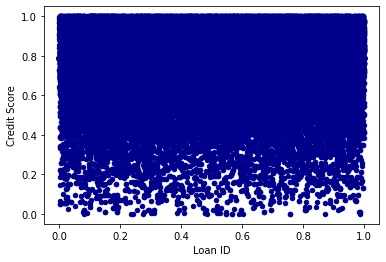

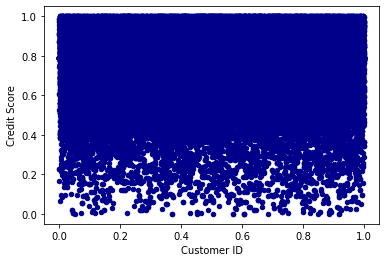

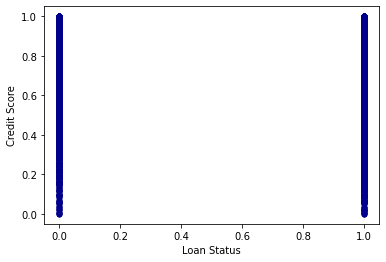

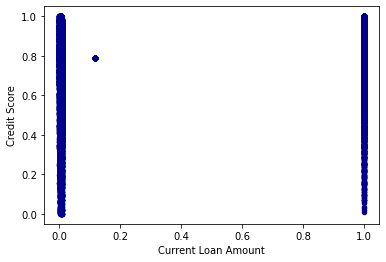

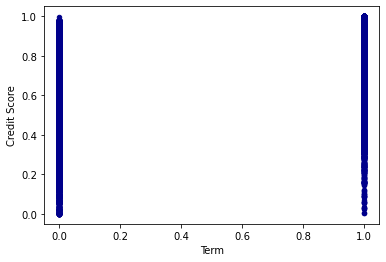

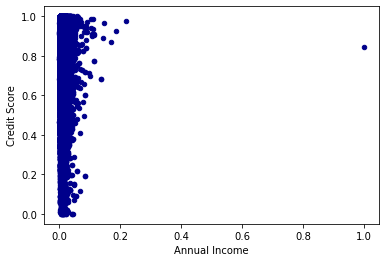

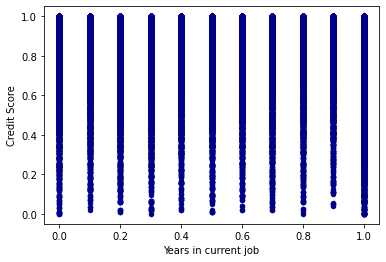

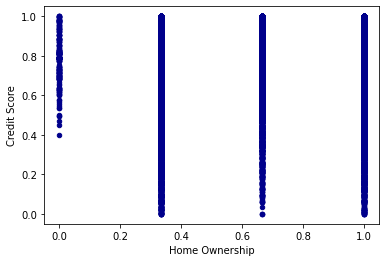

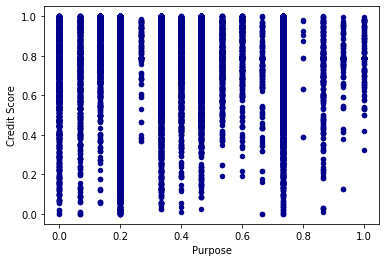

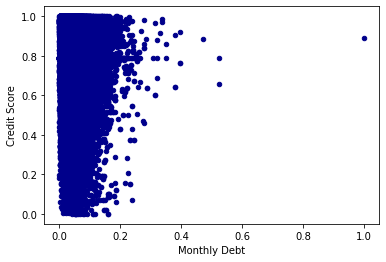

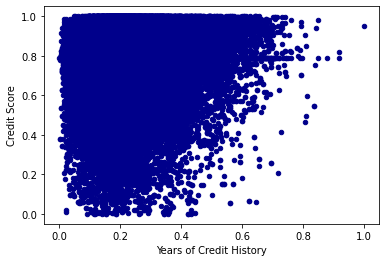

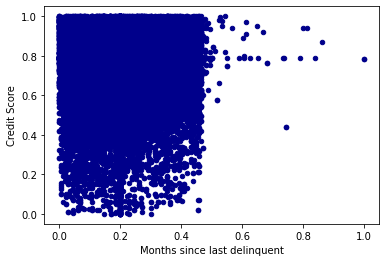

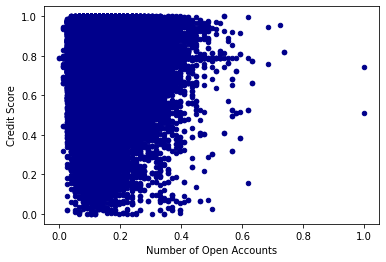

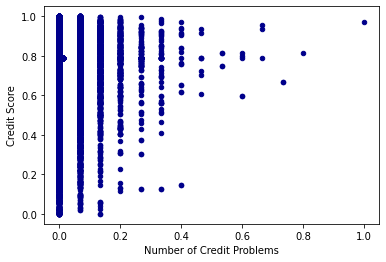

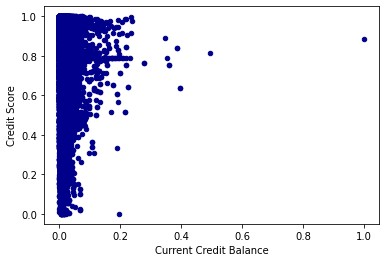

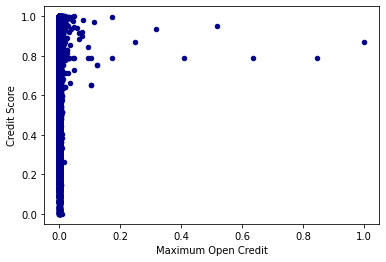

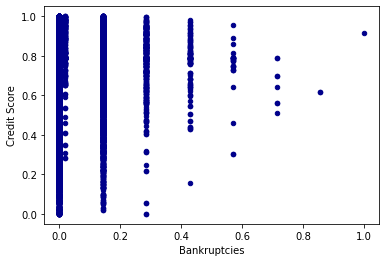

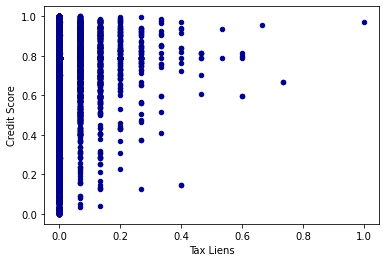

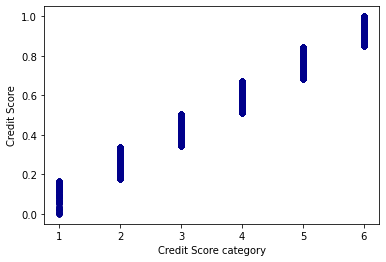

In [42]:
# Visualize all independent variables vs credit score
for col in df.columns:
    if (col != 'Credit Score'):
        df.plot.scatter(x=col, y='Credit Score', c='DarkBlue')

None of the graphs appear to reveal a linear relationship.

In [43]:
# Import libraries
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select X and y columns
y = df['Credit Score']
X = df.drop(columns=['Credit Score',
                     'Loan ID',
                     'Customer ID',
                     'Number of Credit Problems',
                     'Credit Score category'])

# Add constant row to X
X = sm.add_constant(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Train model and predict train/test sets
model = sm.OLS(y_train,X_train).fit()
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Print model summary
print(model.summary(), "\n")

                            OLS Regression Results                            
Dep. Variable:           Credit Score   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     1537.
Date:                Tue, 17 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:28:15   Log-Likelihood:                 48191.
No. Observations:               83150   AIC:                        -9.635e+04
Df Residuals:                   83134   BIC:                        -9.620e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [44]:
# Check for multicollinearities between variables
vif = {var_name: variance_inflation_factor(X_train.values, i) for var_name, i in zip(X_train.columns, range(X_train.shape[1]))}
vif

{'const': 36.545897089945214,
 'Loan Status': 1.0523418936447642,
 'Current Loan Amount': 1.037047925755335,
 'Term': 1.0515201159385732,
 'Annual Income': 1.2491417266715206,
 'Years in current job': 1.0973737501566678,
 'Home Ownership': 1.1263559790020403,
 'Purpose': 1.0123700042211792,
 'Monthly Debt': 1.7309042488410629,
 'Years of Credit History': 1.141847243780973,
 'Months since last delinquent': 1.0124956936080587,
 'Number of Open Accounts': 1.2212564158806904,
 'Current Credit Balance': 1.3791281323372402,
 'Maximum Open Credit': 1.0243358134422382,
 'Bankruptcies': 1.0375106933978298,
 'Tax Liens': 1.0055824450330695}

All VIF values are under 5 (excluding the intercept) implying no strong multicollinearities.

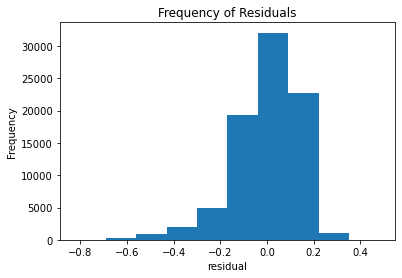

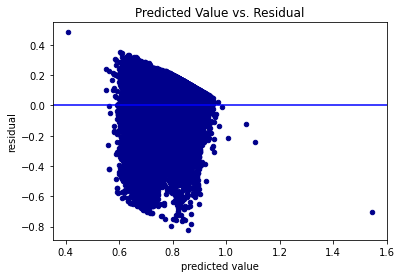

In [45]:
model.resid.plot.hist()
plt.xlabel('residual')
plt.title('Frequency of Residuals')
plt.show()

resid_analysis = pd.DataFrame(columns=['predicted value','residual'])
resid_analysis['predicted value'] = model.predict(X_train)
resid_analysis['residual'] = model.resid
resid_analysis.plot.scatter(x='predicted value',y='residual',c='DarkBlue')
plt.axhline(y=0, color='b', linestyle='-')
plt.title('Predicted Value vs. Residual')
plt.show()

In [46]:
# Print MSE values for train/test sets
print("MSE for training set: ", mean_squared_error(y_train, y_pred_train))
print("MSE for testing set: ", mean_squared_error(y_test, y_pred), "\n")

# Print R2 values for train/test sets
print("R2 score for training set: ", r2_score(y_train, y_pred_train))
print("R2 score for testing set: ", r2_score(y_test, y_pred), "\n")

MSE for training set:  0.01837049555421971
MSE for testing set:  0.0178676821567076 

R2 score for training set:  0.21712106031609868
R2 score for testing set:  0.2138353774357421 



At first glance, graphing the independent variables vs. the dependent variable (credit score) show no strong linear trends. Furthermore, the linear model developed has a low R2 around 0.20 and does not pass residual analysis either. Therefore, a linear model is not a good model for predicting credit score.